In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy

import os 
import glob

In [692]:
glob.glob('D:/gait_dataset/gilon/*_annotation.txt')

['D:/gait_dataset/gilon\\220526_태민우_3km_annotation.txt',
 'D:/gait_dataset/gilon\\220530_김보민_3km_annotation.txt',
 'D:/gait_dataset/gilon\\220530_박준영_3km_annotation.txt',
 'D:/gait_dataset/gilon\\220530_이고은_3km_annotation.txt',
 'D:/gait_dataset/gilon\\220530_이정호_3km_annotation.txt',
 'D:/gait_dataset/gilon\\220602_신수종_3km_annotation.txt',
 'D:/gait_dataset/gilon\\220602_왕준기_3km_annotation.txt',
 'D:/gait_dataset/gilon\\220602_최영찬_3km_annotation.txt',
 'D:/gait_dataset/gilon\\220602_최창환_3km_annotation.txt']

In [693]:
video_gait = []
video_gait_mean = []
pres_gait = []
pres_gait_mean = []

for i in glob.glob('D:/gait_dataset/gilon/*_annotation.txt'):
    df = pd.read_csv(i)
    video_gait.append(df.video)
    video_gait_mean.append(np.mean(df.video))
    pres_gait.append(df.pressure)
    pres_gait_mean.append(np.mean(df.pressure))

video_gait = np.array(list(itertools.chain.from_iterable(video_gait)))
pres_gait = np.array(list(itertools.chain.from_iterable(pres_gait)))
video_gait_mean = np.round(video_gait_mean, 3)
pres_gait_mean = np.round(pres_gait_mean, 3)

In [694]:
video_gait

array([1.207, 1.194, 1.222, ..., 1.151, 1.122, 1.108])

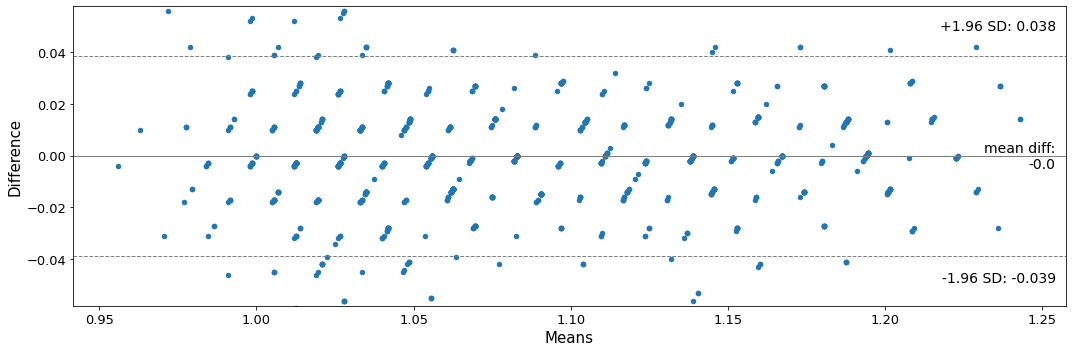

In [699]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (15,5))
sm.graphics.mean_diff_plot(video_gait, pres_gait, ax = ax)
plt.show()

In [696]:
df = {'video' : video_gait_mean, 'pressure ' : pres_gait_mean}
pd.DataFrame(df)

,video,pressure
0,1.157,1.157
1,1.080,1.081
2,1.032,1.032
3,1.079,1.079
4,1.198,1.198
5,1.029,1.029
6,1.016,1.016
7,1.133,1.133
8,1.079,1.079


In [448]:
# 한 사람의 걸음 수에 대해 검정할 경우, video anno에 대해 변수가 많기 때문에 일관적인 결과를 나타내지 않음
# -> 모든 검정 결과가 유의하지 않다고 나오긴 함 : 귀무가설 채택
# 평균을 통해 전체적인 맥락에서 비교가 필요
# 처리의 전후가 아닌 독립적인 처리(not paired)이므로 Mann-Whitney U 검정 실시

scipy.stats.mannwhitneyu(video_gait_mean, pres_gait_mean)

MannwhitneyuResult(statistic=40.0, pvalue=1.0)

# Pressure Stride

In [171]:
# Stride = HS에서 다음 HS까지의 거리
glob.glob('D:/gait_dataset/gilon/*_3km_R.csv')

['D:/gait_dataset/gilon\\김보민_220530_3km_R.csv',
 'D:/gait_dataset/gilon\\박준영_220530_3km_R.csv',
 'D:/gait_dataset/gilon\\신수종_220602_3km_R.csv',
 'D:/gait_dataset/gilon\\왕준기_220602_3km_R.csv',
 'D:/gait_dataset/gilon\\이고은_220530_3km_R.csv',
 'D:/gait_dataset/gilon\\이정호_220530_3km_R.csv',
 'D:/gait_dataset/gilon\\최영찬_220602_3km_R.csv',
 'D:/gait_dataset/gilon\\최창환_220602_3km_R.csv',
 'D:/gait_dataset/gilon\\태민우_220526_3km_R.csv']

In [411]:
df = pd.read_csv('D:\gait_dataset/gilon/태민우_220526_3km_R.csv')
df.columns = ['name', 'addr', 'timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z',
              'pr1', 'pr2', 'pr3', 'p4', 'pr5', 'pr6', 'pr7', 'p8', 'pr9', 'pr10', 'num']

In [412]:
df_prs = df.filter(regex="p")
df_pres_mean = np.mean(df_prs.iloc[:, 1:5], axis=1) # timestep 별 4개 압력 측정값의 평균

In [413]:
min(df_pres_mean)

15.0

interpolation before / after : 9242 / 13863


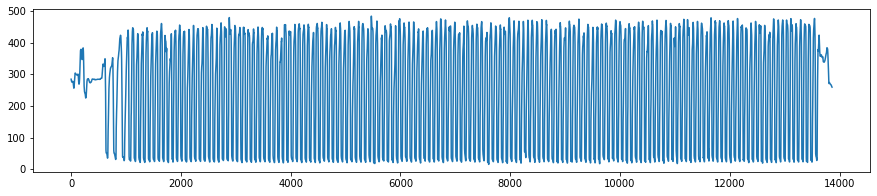

In [414]:
# sampling rate를 영상 frame과 동일하게 통일
sampling_rate = 40
frame = 60
intp = frame / sampling_rate

df_pres_mean_intp = cv2.resize(np.array(df_pres_mean), dsize=(1, int(len(df_pres_mean)*intp)))

plt.figure(figsize=(15,3))
plt.plot(df_pres_mean_intp)
print('interpolation before / after :',len(df_pres_mean), '/', len(df_pres_mean_intp))

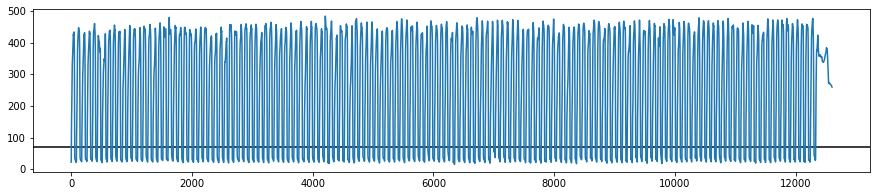

In [430]:
plt.figure(figsize=(15,3))
plt.axhline(y=70, color='k')
plt.plot(df_pres_mean_intp[1259:])

In [431]:
lev_shift = pd.Series(df_pres_mean_intp[1259:].flatten())> 70
lev_shift_int = lev_shift.map(lambda x : 1 if x else 0)
lev_shift_int = lev_shift_int.reset_index(drop=True)

idx = []
for i in range(len(lev_shift_int)-1):
    if (lev_shift_int[i] - lev_shift_int[i+1]) != 0:
        idx.append(i)

In [432]:
gait_unit_hz_shift = np.diff(idx) 
gait_unit_hz_shift

array([55, 31, 57, 31, 57, 31, 56, 31, 53, 29, 56, 27, 58, 26, 55, 28, 53,
       26, 55, 32, 53, 30, 54, 28, 55, 31, 56, 29, 53, 31, 55, 30, 55, 27,
       53, 31, 54, 30, 58, 28, 55, 29, 57, 27, 57, 29, 55, 29, 53, 30, 52,
       28, 55, 30, 57, 30, 54, 32, 54, 27, 54, 27, 54, 28, 55, 33, 53, 29,
       54, 30, 54, 28, 52, 28, 57, 25, 55, 29, 53, 29, 55, 26, 55, 28, 55,
       30, 53, 29, 55, 28, 58, 31, 54, 29, 52, 31, 55, 29, 55, 28, 54, 29,
       52, 29, 55, 28, 55, 28, 56, 31, 54, 30, 52, 28, 56, 30, 53, 31, 54,
       28, 55, 29, 53, 30, 55, 28, 54, 30, 53, 28, 53, 31, 53, 28, 57, 30,
       53, 28, 53, 29, 51, 28, 53, 29, 56, 29, 55, 29, 52, 30, 56, 29, 53,
       30, 58, 28, 55, 30, 54, 29, 54, 28, 54, 31, 54, 30, 56, 27, 54, 28,
       56, 30, 55, 30, 55, 29, 55, 29, 54, 31, 55, 29, 55, 31, 57, 28, 55,
       30, 54, 29, 55, 30, 55, 29, 55, 30, 54, 30, 53, 29, 54, 30, 56, 30,
       55, 28, 54, 28, 56, 28, 56, 28, 55, 29, 57, 30, 54, 28, 55, 25, 56,
       30, 54, 28, 52, 29

In [433]:
gait_unit_sec_shift = gait_unit_hz_shift/60
gait_unit_sec_shift

array([0.91666667, 0.51666667, 0.95      , 0.51666667, 0.95      ,
       0.51666667, 0.93333333, 0.51666667, 0.88333333, 0.48333333,
       0.93333333, 0.45      , 0.96666667, 0.43333333, 0.91666667,
       0.46666667, 0.88333333, 0.43333333, 0.91666667, 0.53333333,
       0.88333333, 0.5       , 0.9       , 0.46666667, 0.91666667,
       0.51666667, 0.93333333, 0.48333333, 0.88333333, 0.51666667,
       0.91666667, 0.5       , 0.91666667, 0.45      , 0.88333333,
       0.51666667, 0.9       , 0.5       , 0.96666667, 0.46666667,
       0.91666667, 0.48333333, 0.95      , 0.45      , 0.95      ,
       0.48333333, 0.91666667, 0.48333333, 0.88333333, 0.5       ,
       0.86666667, 0.46666667, 0.91666667, 0.5       , 0.95      ,
       0.5       , 0.9       , 0.53333333, 0.9       , 0.45      ,
       0.9       , 0.45      , 0.9       , 0.46666667, 0.91666667,
       0.55      , 0.88333333, 0.48333333, 0.9       , 0.5       ,
       0.9       , 0.46666667, 0.86666667, 0.46666667, 0.95   

In [275]:
def twoSum(a, n):
    b = []
    for i in range(0, n, 2):
        if (i == n-1):
            b.append(a[i])
        else:
            b.append(a[i] + a[i+1])

    return b

In [434]:
pres_stride = twoSum(gait_unit_sec_shift, len(gait_unit_sec_shift))
len(twoSum(gait_unit_sec_shift, len(gait_unit_sec_shift)))

148

In [435]:
video_stride = pd.read_csv('태민우.txt', header=None)
len(video_stride)

144

In [437]:
len(pres_stride[:len(video_stride)])

144

In [438]:
pres_stride = np.round(np.round(pres_stride[:len(video_stride)], 3) * (3000/3600), 3)

In [439]:
scipy.stats.mannwhitneyu(pres_stride, video_stride)

MannwhitneyuResult(statistic=array([10577.]), pvalue=array([0.76533302]))

In [407]:
pres_stride

array([1.125, 1.069, 1.056, 1.028, 1.028, 1.028, 1.042, 1.028, 1.111,
       1.069, 0.986, 1.028, 1.   , 1.028, 1.042, 1.014, 1.042, 0.986,
       1.125, 1.014, 1.056, 1.056, 1.056, 1.069, 1.125, 1.056, 1.056,
       1.028, 1.056, 1.083, 1.042, 1.083, 1.083, 1.056, 1.083, 1.098,
       1.042, 1.069, 1.028, 1.056, 1.042, 1.042, 1.028, 1.069, 1.083,
       1.098, 1.111, 1.042, 1.083, 1.083, 1.056, 1.014, 1.042, 1.028,
       1.056, 1.014, 1.111, 1.042, 1.069, 1.083, 1.083, 1.152, 1.111,
       1.098, 1.125, 1.098, 1.056, 1.125, 1.056, 1.098, 1.056, 1.056,
       1.069, 1.028, 1.139, 1.083, 1.111, 1.125, 1.056, 1.042, 1.069,
       1.056, 1.069, 1.125, 1.098, 1.152, 1.139, 1.139, 1.125, 1.098,
       1.098, 1.098, 1.028, 1.125, 1.042, 1.042, 1.083, 1.098, 1.014,
       1.125, 1.083, 1.069, 1.125, 1.098, 1.152, 1.111, 1.098, 1.152,
       1.125, 1.069, 1.014, 1.083, 1.056, 1.139, 1.083, 1.111, 1.014,
       1.056, 1.069, 1.   , 1.056, 1.152, 1.139, 1.069, 1.111, 1.098,
       1.152, 1.139,

In [427]:
video_stride

,0
0,1.207
1,1.194
2,1.222
3,1.194
4,1.167
...,...
139,1.139
140,1.111
141,1.139
142,1.138


In [440]:
df = {'video' : np.array(video_stride).flatten(), 'pressure' : pres_stride}

In [441]:
pd.DataFrame(df).to_csv('D:/gait_dataset/gilon/220526_태민우_3km_annotation.txt', index=False)

# Video Stride

In [211]:
glob.glob('D:/gait_dataset/gilon/*_3km.txt')

['D:/gait_dataset/gilon\\김보민_220530_3km.txt',
 'D:/gait_dataset/gilon\\박준영_220530_3km.txt',
 'D:/gait_dataset/gilon\\신수종_220602_3km.txt',
 'D:/gait_dataset/gilon\\왕준기_220602_3km.txt',
 'D:/gait_dataset/gilon\\이고은_220530_3km.txt',
 'D:/gait_dataset/gilon\\이정호_220530_3km.txt',
 'D:/gait_dataset/gilon\\최영찬_220602_3km.txt',
 'D:/gait_dataset/gilon\\최창환_220602_3km.txt',
 'D:/gait_dataset/gilon\\태민우_220526_3km.txt']

In [216]:
df_video = pd.read_csv('D:/gait_dataset/gilon\\김보민_220530_3km.txt', sep='\t', header=None)
df_video

,0,1,2,3,4,5,6,7,8
0,default,NaN,00:00:00.133,0.133,00:00:01.033,1.033,00:00:00.900,0.900,NaN
1,default,NaN,00:00:01.433,1.433,00:00:02.333,2.333,00:00:00.900,0.900,NaN
2,default,NaN,00:00:02.766,2.766,00:00:03.600,3.600,00:00:00.834,0.834,NaN
3,default,NaN,00:00:04.033,4.033,00:00:04.900,4.900,00:00:00.867,0.867,NaN
4,default,NaN,00:00:05.366,5.366,00:00:06.233,6.233,00:00:00.867,0.867,NaN
...,...,...,...,...,...,...,...,...,...
135,default,NaN,00:02:55.333,175.333,00:02:56.166,176.166,00:00:00.833,0.833,NaN
136,default,NaN,00:02:56.600,176.600,00:02:57.433,177.433,00:00:00.833,0.833,NaN
137,default,NaN,00:02:57.833,177.833,00:02:58.666,178.666,00:00:00.833,0.833,NaN
138,default,NaN,00:02:59.066,179.066,00:02:59.966,179.966,00:00:00.900,0.900,NaN


In [218]:
np.array(df_video.loc[1:, 3]) - np.array(df_video.loc[:len(df_video)-2, 5])

array([0.4  , 0.433, 0.433, 0.466, 0.433, 0.467, 0.433, 0.433, 0.433,
       0.434, 0.4  , 0.4  , 0.434, 0.4  , 0.466, 0.433, 0.433, 0.4  ,
       0.4  , 0.467, 0.467, 0.433, 0.434, 0.467, 0.467, 0.434, 0.467,
       0.433, 0.433, 0.467, 0.433, 0.434, 0.433, 0.434, 0.434, 0.434,
       0.467, 0.4  , 0.4  , 0.433, 0.4  , 0.4  , 0.43 , 0.433, 0.434,
       0.433, 0.4  , 0.433, 0.4  , 0.4  , 0.433, 0.4  , 0.4  , 0.433,
       0.4  , 0.4  , 0.4  , 0.434, 0.4  , 0.433, 0.4  , 0.4  , 0.433,
       0.4  , 0.4  , 0.433, 0.466, 0.433, 0.433, 0.434, 0.4  , 0.467,
       0.467, 0.4  , 0.434, 0.467, 0.434, 0.433, 0.5  , 0.467, 0.467,
       0.466, 0.467, 0.466, 0.434, 0.433, 0.433, 0.433, 0.433, 0.433,
       0.4  , 0.367, 0.367, 0.434, 0.434, 0.4  , 0.434, 0.4  , 0.466,
       0.4  , 0.434, 0.4  , 0.467, 0.467, 0.433, 0.433, 0.433, 0.4  ,
       0.433, 0.4  , 0.433, 0.433, 0.467, 0.467, 0.4  , 0.4  , 0.433,
       0.4  , 0.433, 0.4  , 0.433, 0.433, 0.433, 0.433, 0.4  , 0.4  ,
       0.4  , 0.4  ,

In [220]:
stride = np.array(df_video.loc[:len(df_video)-2, 7]) + (np.array(df_video.loc[1:, 3]) - np.array(df_video.loc[:len(df_video)-2, 5]))
stride

array([1.3  , 1.333, 1.267, 1.333, 1.3  , 1.334, 1.266, 1.3  , 1.3  ,
       1.334, 1.3  , 1.3  , 1.3  , 1.266, 1.3  , 1.3  , 1.3  , 1.267,
       1.267, 1.333, 1.3  , 1.3  , 1.267, 1.3  , 1.3  , 1.3  , 1.4  ,
       1.333, 1.333, 1.367, 1.333, 1.334, 1.333, 1.367, 1.3  , 1.3  ,
       1.3  , 1.266, 1.3  , 1.3  , 1.234, 1.266, 1.33 , 1.333, 1.267,
       1.266, 1.267, 1.3  , 1.204, 1.233, 1.3  , 1.234, 1.266, 1.267,
       1.233, 1.3  , 1.267, 1.267, 1.233, 1.333, 1.267, 1.267, 1.266,
       1.267, 1.3  , 1.333, 1.3  , 1.3  , 1.3  , 1.334, 1.3  , 1.333,
       1.367, 1.3  , 1.4  , 1.4  , 1.3  , 1.366, 1.4  , 1.367, 1.367,
       1.366, 1.367, 1.333, 1.334, 1.366, 1.367, 1.3  , 1.3  , 1.3  ,
       1.267, 1.233, 1.3  , 1.267, 1.3  , 1.3  , 1.3  , 1.266, 1.3  ,
       1.234, 1.3  , 1.3  , 1.333, 1.3  , 1.333, 1.267, 1.3  , 1.3  ,
       1.333, 1.234, 1.333, 1.3  , 1.3  , 1.3  , 1.267, 1.266, 1.3  ,
       1.234, 1.266, 1.267, 1.3  , 1.333, 1.3  , 1.267, 1.267, 1.3  ,
       1.233, 1.267,

In [ ]:
video = np.round(stride * (3000/3600), 3)
video

In [170]:
pd.Series(video).to_csv('태민우.txt', index=False, header=None)

# Integral

In [703]:
df = pd.read_csv('D:\gait_dataset/gilon/이정호_220530_3km_R.csv')
df.columns = ['name', 'addr', 'timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z',
              'pr1', 'pr2', 'pr3', 'p4', 'pr5', 'pr6', 'pr7', 'p8', 'pr9', 'pr10', 'num']

In [704]:
df

,name,addr,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,pr1,pr2,pr3,p4,pr5,pr6,pr7,p8,pr9,pr10,num
0,PSPODR,F6:9C:4F:EE:60:45,1653883245744,-11,-10,-31,0,0,0,0,9,10,47,0,0,0,0,0,0,0
1,PSPODR,F6:9C:4F:EE:60:45,1653883245745,-11,-4,-33,0,0,0,0,7,8,49,0,0,0,0,0,0,0
2,PSPODR,F6:9C:4F:EE:60:45,1653883245781,-11,3,-37,0,0,0,0,5,6,51,0,0,0,0,0,0,1
3,PSPODR,F6:9C:4F:EE:60:45,1653883245781,-10,12,-42,0,0,0,0,4,6,52,0,0,0,0,0,0,1
4,PSPODR,F6:9C:4F:EE:60:45,1653883245869,-10,15,-48,0,0,0,0,3,10,52,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7319,PSPODR,F6:9C:4F:EE:60:45,1653883428664,1,64,-19,0,0,0,0,0,25,45,0,0,0,0,0,0,75
7320,PSPODR,F6:9C:4F:EE:60:45,1653883428705,4,62,-22,0,0,0,0,0,20,116,0,0,0,0,0,0,76
7321,PSPODR,F6:9C:4F:EE:60:45,1653883428707,4,-3,-34,0,0,0,0,0,11,460,0,0,0,0,0,0,76
7322,PSPODR,F6:9C:4F:EE:60:45,1653883428755,-17,9,-46,0,0,0,0,0,6,586,0,0,0,0,0,0,77


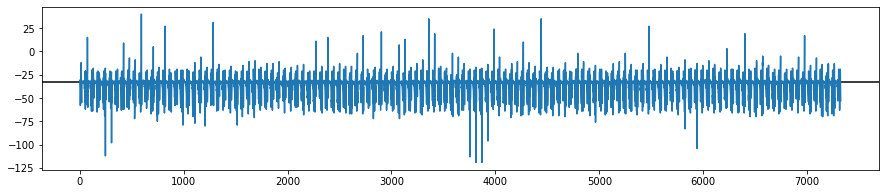

In [705]:
plt.figure(figsize=(15,3))
plt.axhline(y=-33, color='k')
plt.plot(df.acc_z)

In [706]:
# acc_z = (df.acc_z - (-33))
acc = (df.acc_z - np.mean(df.acc_z))
acc

0        6.648553
1        4.648553
2        0.648553
3       -4.351447
4      -10.351447
          ...    
7319    18.648553
7320    15.648553
7321     3.648553
7322    -8.351447
7323   -15.351447
Name: acc_z, Length: 7324, dtype: float64

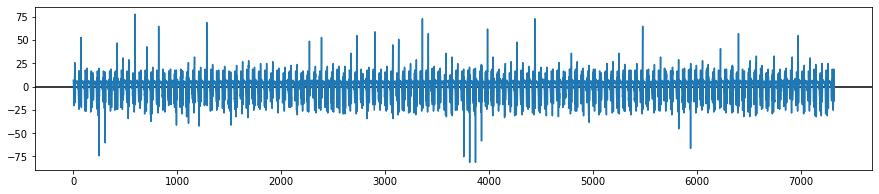

In [707]:
plt.figure(figsize=(15,3))
plt.axhline(y=0, color='k')
plt.plot(acc)

In [708]:
speed = []

sp = 0
for i in range(len(acc)-1):
    vel = sp + 0.5*(acc[i] + acc[i+1])*(1/40)    
    sp =+ vel
    speed.append(sp)

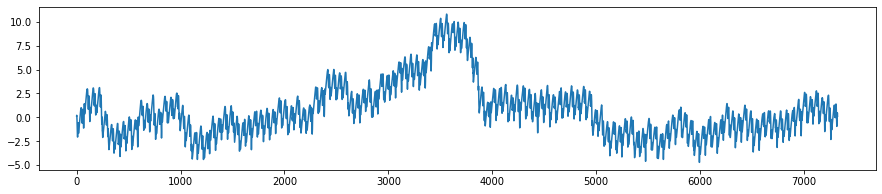

In [709]:
plt.figure(figsize=(15,3))
plt.plot(speed)

In [710]:
np.mean(speed)

0.7640482042878187

In [713]:
distance = []

d = 0
di = 0
dos = 0
for i in range(len(speed)-1):
    vel = di + 0.5*(speed[i] +speed[i+1])*(1/40)    
    di =+ vel
    dos =+ np.abs(vel)
    distance.append(di)

In [714]:
dos

139.87499999999216

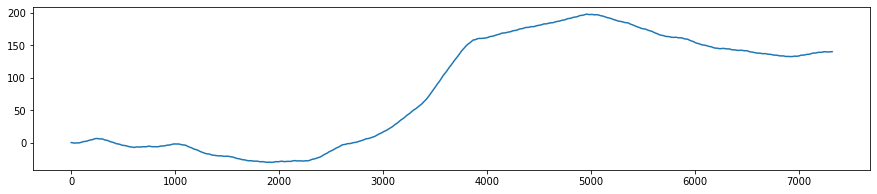

In [712]:
plt.figure(figsize=(15,3))
plt.plot(distance)

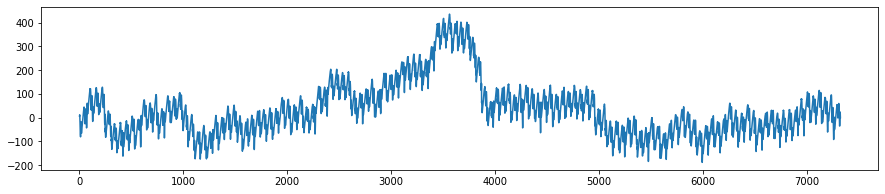

In [565]:
speed = list(itertools.accumulate(acc_z))
plt.figure(figsize=(15,3))
plt.plot(speed)

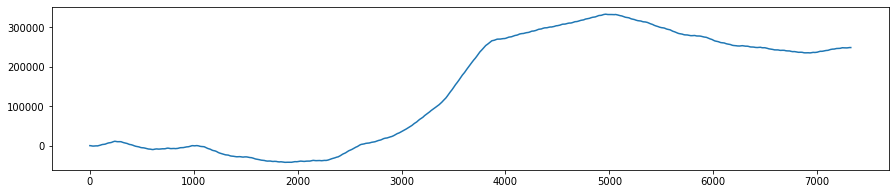

In [566]:
# m
distance = list(itertools.accumulate(speed))
plt.figure(figsize=(15,3))
plt.plot(distance)

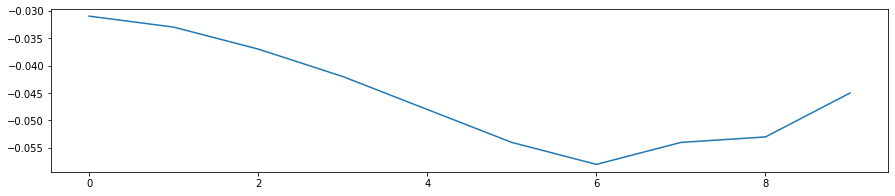

In [484]:
# m/s^2
acc = (df.acc_z / 1000) 
plt.figure(figsize=(15,3))
plt.plot(acc[:10])

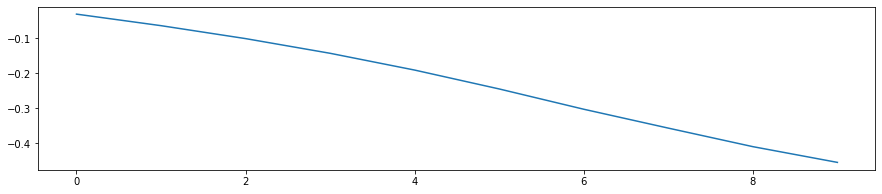

In [485]:
# m/s
speed = list(itertools.accumulate(acc))
plt.figure(figsize=(15,3))
plt.plot(speed[:10])

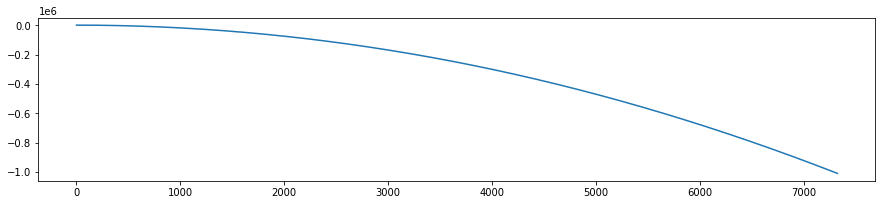

In [486]:
# m
distance = list(itertools.accumulate(speed))
plt.figure(figsize=(15,3))
plt.plot(distance)

In [488]:
distance[400]

-3032.2670000000007

In [493]:
np.sqrt(df.acc_x**2 + df.acc_y**2 + df.acc_z**2)

0       34.380227
1       35.014283
2       38.716921
3       44.810713
4       51.273775
          ...    
7319    66.768256
7320    65.909028
7321    34.365681
7322    49.859803
7323    53.084838
Length: 7324, dtype: float64

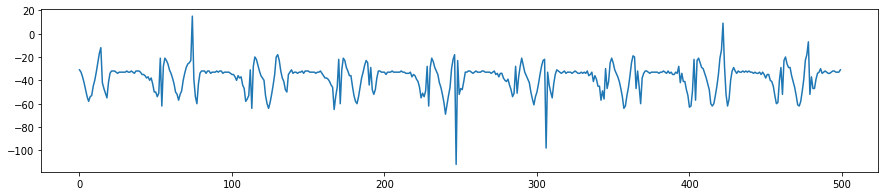

In [495]:
plt.figure(figsize=(15,3))
plt.plot(df.acc_z[:500])

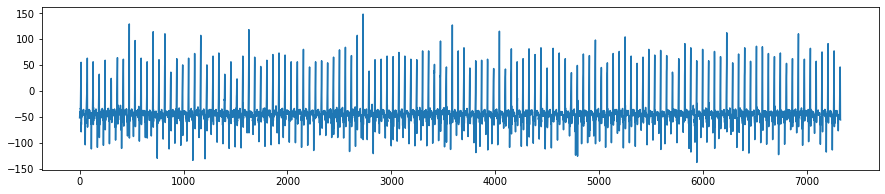

In [502]:
plt.figure(figsize=(15,3))
plt.plot((df.acc_x + df.acc_y + df.acc_z))

In [510]:
acc = df.acc_y 

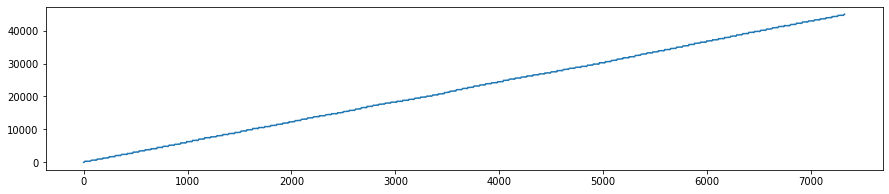

In [512]:
# m/s
speed = list(itertools.accumulate(acc))
plt.figure(figsize=(15,3))
plt.plot(speed)

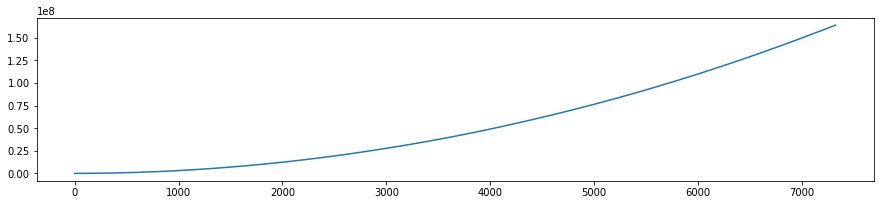

In [513]:
# m
distance = list(itertools.accumulate(speed))
plt.figure(figsize=(15,3))
plt.plot(distance)

In [514]:
distance

[-10,
 -24,
 -35,
 -34,
 -18,
 18,
 78,
 165,
 272,
 408,
 576,
 779,
 1026,
 1327,
 1684,
 2013,
 2342,
 2670,
 3000,
 3333,
 3665,
 3995,
 4324,
 4653,
 4982,
 5304,
 5627,
 5950,
 6273,
 6598,
 6923,
 7247,
 7569,
 7891,
 8216,
 8542,
 8866,
 9192,
 9521,
 9851,
 10181,
 10511,
 10842,
 11173,
 11508,
 11844,
 12186,
 12530,
 12878,
 13234,
 13604,
 13981,
 14373,
 14759,
 15128,
 15473,
 15803,
 16119,
 16416,
 16704,
 16990,
 17281,
 17586,
 17905,
 18246,
 18611,
 19005,
 19428,
 19882,
 20369,
 20889,
 21442,
 22029,
 22658,
 23319,
 23967,
 24616,
 25265,
 25916,
 26568,
 27223,
 27874,
 28522,
 29168,
 29816,
 30465,
 31111,
 31757,
 32402,
 33047,
 33686,
 34328,
 34974,
 35619,
 36255,
 36889,
 37526,
 38163,
 38800,
 39434,
 40070,
 40708,
 41354,
 42007,
 42662,
 43324,
 43992,
 44673,
 45366,
 46075,
 46802,
 47538,
 48274,
 48986,
 49678,
 50356,
 51020,
 51670,
 52309,
 52941,
 53571,
 54204,
 54851,
 55512,
 56197,
 56905,
 57646,
 58428,
 59252,
 60137,
 61092,
 62111

In [509]:
5589 / 85

65.75294117647059

In [538]:
acc_vec =  (df.acc_x * 9.8 * (1/40)) + (df.acc_y * 9.8 * (1/40)) +(df.acc_z * (9.8) * (1/40)) 
acc_vec

0      -12.740
1      -11.760
2      -11.025
3       -9.800
4      -10.535
         ...  
7319    11.270
7320    10.780
7321    -8.085
7322   -13.230
7323   -13.720
Length: 7324, dtype: float64

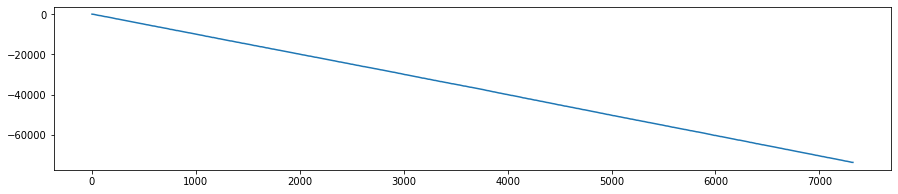

In [539]:
# m/s
speed = list(itertools.accumulate(acc_vec))
plt.figure(figsize=(15,3))
plt.plot(speed)

In [542]:
np.array(speed) * 3.6

array([-4.58640000e+01, -8.82000000e+01, -1.27890000e+02, ...,
       -2.65009248e+05, -2.65056876e+05, -2.65106268e+05])

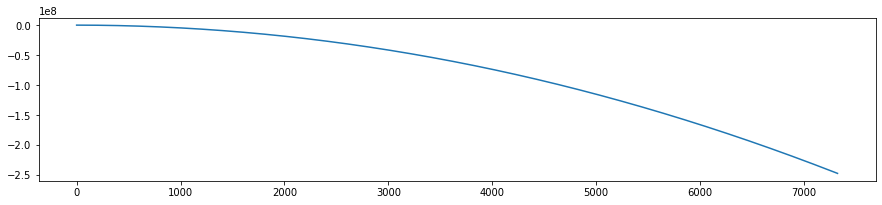

In [535]:
# m/s
dist = list(itertools.accumulate(speed))
plt.figure(figsize=(15,3))
plt.plot(dist)

In [526]:
np.array(speed) / 183.1

array([-6.95794648e-02, -1.33806663e-01, -1.94019661e-01, ...,
       -4.02040852e+02, -4.02113108e+02, -4.02188039e+02])

In [523]:
len(df) / 40

183.1

# Salted 전처리

In [819]:
df = pd.read_csv('D:\gait_dataset/salted/왕준기_220608_3km.csv', skiprows=2)
df

,date,timestamp,L_value1,L_value2,L_value3,L_value4,R_value1,R_value2,R_value3,R_value4,...,R_value5_raw,R_value6_raw,L_GYRO_X,L_GYRO_Y,L_GYRO_Z,R_GYRO_X,R_GYRO_Y,R_GYRO_Z,L_TEMPERATURE,R_TEMPERATURE
0,Wed Jun 08 11:05:57 GMT+09:00 2022,40350,0,0,0,0,39,0,25,56,...,0,0,2524,278,381,-150,3,18,4900,23050
1,Wed Jun 08 11:05:57 GMT+09:00 2022,40360,0,0,0,0,42,0,27,52,...,0,0,2539,287,336,-169,1,20,4900,23050
2,Wed Jun 08 11:05:57 GMT+09:00 2022,40370,0,0,0,0,46,0,30,47,...,0,0,2564,275,367,-188,9,21,4900,23050
3,Wed Jun 08 11:05:57 GMT+09:00 2022,40380,0,0,0,0,50,0,33,41,...,0,0,2565,243,447,-205,13,25,4800,23150
4,Wed Jun 08 11:05:57 GMT+09:00 2022,40390,0,0,0,0,53,0,35,34,...,0,0,2512,219,527,-221,15,31,4800,23150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19931,Wed Jun 08 11:09:14 GMT+09:00 2022,239650,0,0,0,66,77,9,41,0,...,0,0,-1273,-237,37,-2031,441,275,15600,-31386
19932,Wed Jun 08 11:09:14 GMT+09:00 2022,239660,0,0,0,70,74,5,37,0,...,0,0,-1612,-177,5,-2420,507,332,15250,-31486
19933,Wed Jun 08 11:09:14 GMT+09:00 2022,239670,0,0,0,74,71,2,33,0,...,0,0,-1039,-27,25,-2800,627,395,15250,-31486
19934,Wed Jun 08 11:09:14 GMT+09:00 2022,239680,0,0,0,77,67,0,29,0,...,0,0,-515,-12,-24,-3168,701,454,15250,-31486


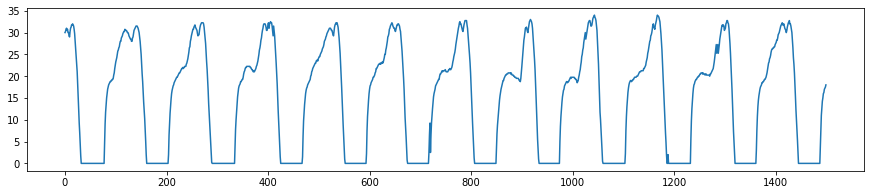

In [818]:
# 오른쪽 압력값 평균
right_prs = df.filter(regex="R_value")
right_pres_mean = np.mean(right_prs.iloc[:, 0:4], axis=1) # timestep 별 4개 압력 측정값의 평균
plt.figure(figsize=(15,3))
plt.plot(right_pres_mean[:1500])

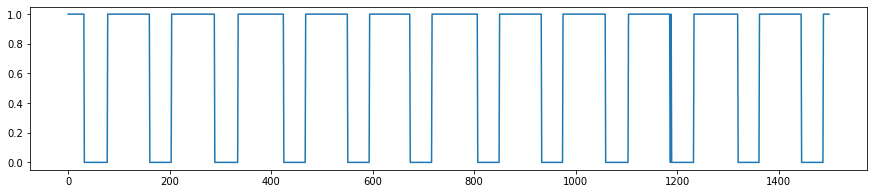

In [816]:
# 오른쪽 압력값을 바이너리로 표현
lev_idx = right_pres_mean > 1
right_pres_lev = lev_idx.map(lambda x : 1 if x else 0)
plt.figure(figsize=(15,3))
plt.plot(right_pres_lev[:1500])

In [791]:
acc = (df.R_ACC_Y/1000 )* 9.8066
# acc = acc_z - np.mean(acc_z)

In [798]:
list(itertools.accumulate(acc))

[0.49033,
 0.931627,
 1.4121504,
 1.7553814,
 2.2359048,
 2.9125602,
 3.383277,
 3.9814796,
 4.511036,
 5.5603422,
 6.5802286,
 7.0313322,
 8.3650298,
 9.5810482,
 10.6695808,
 11.9444388,
 14.1607304,
 15.4650082,
 16.4947012,
 17.3969084,
 19.1424832,
 21.1038032,
 23.133769400000002,
 24.9381838,
 26.3699474,
 28.6646918,
 32.2931338,
 36.451132199999996,
 39.8049894,
 41.854568799999996,
 44.443511199999996,
 44.7573224,
 42.8156156,
 33.34244,
 19.966237600000003,
 13.297749600000003,
 4.138385200000004,
 -4.363936999999996,
 -8.776906999999996,
 -13.003551599999994,
 -17.544007399999995,
 -21.858911399999993,
 -26.526852999999992,
 -31.47918599999999,
 -36.323646399999994,
 -40.89352199999999,
 -45.02210059999999,
 -48.54266999999999,
 -51.25909819999999,
 -53.17138519999999,
 -54.28933759999999,
 -54.69140819999999,
 -54.45604979999999,
 -53.40674359999999,
 -51.44542359999999,
 -49.48410359999999,
 -46.64999619999999,
 -43.24710599999999,
 -39.442145199999985,
 -35.235113799999

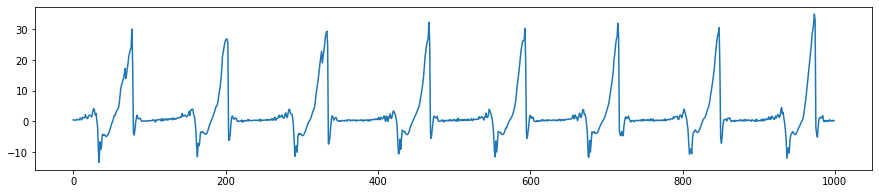

In [792]:
plt.figure(figsize=(15,3))
plt.plot(acc[:1000])

In [793]:
speed = []

sp = 0
for i in range(len(acc)-1):
    vel = sp + 0.5*(acc[i] + acc[i+1])*(1/100)    
    sp =+ vel
    speed.append(sp)

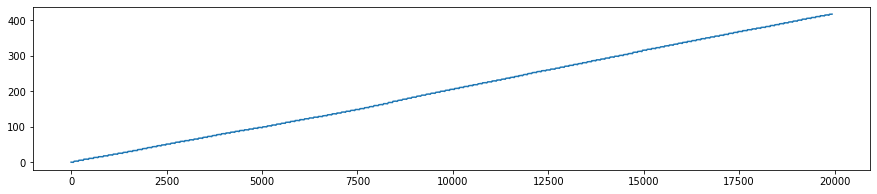

In [794]:
plt.figure(figsize=(15,3))
plt.plot(speed)

In [795]:
distance = []

d = 0
di = 0
dos = 0
for i in range(len(speed)-1):
    vel = di + 0.5*(speed[i] +speed[i+1])*(1/40)    
    di =+ vel
    distance.append(di)

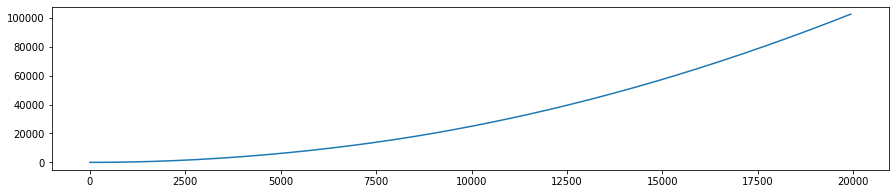

In [796]:
plt.figure(figsize=(15,3))
plt.plot(distance)

In [770]:
180 * (3000/3600)

150.0